# Tarea 2 - Tel341: Simulación de Redes 2024-1

## Nombre: Pedro Arce.

## Introducción

En esta tarea, se desarrolla un simulador para modelar el comportamiento de una red de transporte de internet de fibra óptica. La red está compuesta por N nodos y L enlaces unidireccionales, cada uno con una capacidad C medida en longitudes de onda.

Los usuarios de la red tienen rutas fijas pre-calculadas para transmitir datos, y el tráfico generado en la red sigue un proceso Poisson, con distribuciones exponenciales para los tiempos de transmisión y servicio. La red no admite colas de espera, por lo que las solicitudes de conexión son aceptadas solo si todos los enlaces en la ruta del usuario tienen al menos una longitud de onda disponible durante toda la transmisión.

El objetivo de este simulador es evaluar la probabilidad de bloqueo tanto para cada usuario como para la red en su conjunto. La simulación se ejecuta para diversas topologías de red, considerando una carga de tráfico media de 0.3*X, donde X es el número de conexiones de la red.

## Objetivos

1. Modelar la red de transporte de internet utilizando un enfoque de simulación.
2. Calcular las probabilidades de bloqueo de las conexiones y la red.
3. Generar gráficos que muestren la relación entre la capacidad asignada a cada enlace y la probabilidad de bloqueo.
4. Evaluar el desempeño de diferentes topologías de red bajo diversas condiciones de tráfico.

## Metodología

- Se definen las variables y el estado inicial del sistema.
- Se gestionan los eventos en la línea de tiempo para reconocer las llegadas y salidas de los usuarios.
- Se utiliza un número finito de llegadas de usuarios como criterio de parada.
- Se calculan las métricas al finalizar la simulación, incluyendo las probabilidades de bloqueo de los usuarios y de la red.

## Topologías de Red

La simulación se ejecuta para las siguientes topologías de red:

1. Eurocore
2. NSFNet
3. UKNet
4. USNet

## Resultados

Los resultados incluyen gráficos de la probabilidad de bloqueo de la red versus la capacidad del enlace, y gráficos de la probabilidad de bloqueo de los usuarios por longitud de ruta para cada topología de red.

In [1]:
###Definir las funciones auxiliares y preparar los datos de topología

import json
import pandas as pd
import numpy as np
from heapq import heappush, heappop
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import time

#def parámetros de la simulación
C_inicial = 3 #capacidad inicial realista (número arbitrario)
LLEGADAS = 10**5
u = 1    #tasa media de servicio

#función para gen tiempos exp
def randExp(tasa_media):
    return np.random.exponential(1/tasa_media)

#función para agregar valores iniciales a la FEL
def Agregar_Valores_Iniciales_A_FEL(M, tasa_media):
    Lista = []
    for i in range(M):
        heappush(Lista, (randExp(tasa_media), i, "Llegada"))
    return Lista

In [2]:
###Leer las topologías de red

#leer arch de topología y agregarlo a un DataFrame
def leer_topologia(archivo):
    with open(archivo, 'r') as f:
        data = json.load(f)  #leer el arch json
    shortest_paths = []
    nodos_unicos = set()  #inicializar conjunto de nodos únicos
    for route in data['routes']:
        nodos_unicos.add(route['src'])  #agregar nodo de origen al conjunto
        nodos_unicos.add(route['dst'])  #agregar nodo de destino al conjunto
        src = route['src']
        dst = route['dst']
        shortest_path = min(route['paths'], key=len)  #encontrar la ruta más corta
        shortest_paths.append({'src': src, 'dst': dst, 'shortest_path': shortest_path})  #agregar ruta a la lista
    df_shortest_paths = pd.DataFrame(shortest_paths)  #crear dataframe de rutas cortas
    N = len(nodos_unicos)  #calcular el número de nodos únicos
    M = N * (N - 1)  #calcular el número de usuarios
    df_expanded_paths = df_shortest_paths['shortest_path'].apply(pd.Series)  #expandir rutas a columnas
    df_expanded_paths.columns = ['path{}'.format(i + 1) for i in range(df_expanded_paths.shape[1])]  #renombrar columnas
    df_final = pd.concat([df_shortest_paths[['src', 'dst']], df_expanded_paths], axis=1)  #combinar columnas de origen, destino y rutas
    connections = []
    for index, row in df_final.iterrows():
        path = row.dropna().tolist()[2:]  #obtener la ruta eliminando valores NaN
        for i in range(len(path) - 1):
            connection = (path[i], path[i + 1])
            connections.append(connection)  #agregar conexión a la lista
    connection_counts = pd.Series(connections).value_counts().reset_index()  #contar conexiones
    connection_counts.columns = ['Enlace', 'Cantidad']  #renombrar columnas
    connection_counts_sorted = connection_counts.sort_values(by=['Enlace']).reset_index(drop=True)  #ordenar conexiones
    X = connection_counts_sorted['Cantidad'].sum()  #calcular el número de conexiones
    connection_to_id = {tuple(enlace): idx for idx, enlace in enumerate(connection_counts_sorted['Enlace'])}  #crear diccionario de conexiones a ids
    new_table_data = []
    for index, row in df_final.iterrows():
        src = row['src']
        dst = row['dst']
        path = row.dropna().tolist()[2:]  #obtener la ruta eliminando valores NaN
        enlace_rutas = []
        for i in range(len(path) - 1):
            connection = (path[i], path[i + 1])
            enlace_rutas.append(connection_to_id[connection])  #agregar id de conexión a la lista
        new_table_data.append({'Origen': src, 'Destino': dst, 'LEN': len(enlace_rutas), 'RUTA': enlace_rutas})  #agregar ruta a la nueva tabla
    dfRuta = pd.DataFrame(new_table_data)  #crear dataframe de rutas
    return dfRuta, connection_counts_sorted, N, M, X  #retornar dataframes, conteos y número de conexiones

#leer archivos de topología y preparar los DataFrames
dfRuta_eurocore, connection_counts_sorted_eurocore, N_eurocore, M_eurocore, X_eurocore = leer_topologia('Eurocore_routes.json')
dfRuta_nsfnet, connection_counts_sorted_nsfnet, N_nsfnet, M_nsfnet, X_nsfnet = leer_topologia('NSFNet_routes.json')
dfRuta_uknet, connection_counts_sorted_uknet, N_uknet, M_uknet, X_uknet = leer_topologia('UKNet_routes.json')
dfRuta_usnet, connection_counts_sorted_usnet, N_usnet, M_usnet, X_usnet = leer_topologia('USNet_routes.json')

#def la tasa de llegada basada en la carga de tráfico media de la red
l_eurocore = 0.3 * X_eurocore
l_nsfnet = 0.3 * X_nsfnet
l_uknet = 0.3 * X_uknet
l_usnet = 0.3 * X_usnet

#crear diccionario para las topologías
topologias = {
    'Eurocore': (dfRuta_eurocore, connection_counts_sorted_eurocore, N_eurocore, M_eurocore, l_eurocore),
    'NSFNet': (dfRuta_nsfnet, connection_counts_sorted_nsfnet, N_nsfnet, M_nsfnet, l_nsfnet),
    'UKNet': (dfRuta_uknet, connection_counts_sorted_uknet, N_uknet, M_uknet, l_uknet),
    'USNet': (dfRuta_usnet, connection_counts_sorted_usnet, N_usnet, M_usnet, l_usnet)
}

In [3]:
###Definir la clase "RedSimulacion" con la FEL

class RedSimulacion:
    def __init__(self, dfRuta, connection_counts_sorted, num_llegadas, capacidad, tasa_llegada, tasa_servicio):
        self.dfRuta = dfRuta  #guardar dataframe de rutas
        self.connection_counts_sorted = connection_counts_sorted  #guardar conexiones ordenadas
        self.num_llegadas = num_llegadas  #guardar número de llegadas
        self.capacidad = capacidad  #guardar capacidad de enlaces
        self.tasa_llegada = tasa_llegada  #guardar tasa de llegada
        self.tasa_servicio = tasa_servicio  #guardar tasa de servicio
        self.enlaces = np.full(len(connection_counts_sorted), capacidad)  #inicializar capacidad de enlaces
        self.eventos = Agregar_Valores_Iniciales_A_FEL(num_llegadas, tasa_llegada)  #inicializar la lista de eventos futuros
        self.usuarios = np.zeros((num_llegadas, 2), dtype=int)  #inicializar matriz de usuarios
        self.llegadas_completadas = 0  #inicializar contador de llegadas completadas
        self.bloqueos = 0  #inicializar contador de bloqueos

    def procesar_eventos(self):
        while self.usuarios[:, 1].sum() < LLEGADAS:
            Tiempo_Actual, ID_Usuario, Tipo_Evento = heappop(self.eventos)  #extraer el siguiente evento
            if Tipo_Evento == "Llegada":
                self.procesar_llegada(ID_Usuario, Tiempo_Actual)  #procesar evento de llegada
            elif Tipo_Evento == "Salida":
                self.procesar_salida(ID_Usuario, Tiempo_Actual)  #procesar evento de salida

    def procesar_llegada(self, ID_Usuario, Tiempo_Actual):
        ruta = self.dfRuta.loc[ID_Usuario, 'RUTA']  #obtener la ruta del usuario
        if np.all(self.enlaces[ruta] > 0):  #verificar si hay capacidad en la ruta
            self.enlaces[ruta] -= 1  #disminuir capacidad de los enlaces en la ruta
            tiempo_servicio = randExp(self.tasa_servicio)  #calcular tiempo de servicio
            heappush(self.eventos, (Tiempo_Actual + tiempo_servicio, ID_Usuario, "Salida"))  #agregar evento de salida
            self.usuarios[ID_Usuario, 1] += 1  #incrementar contador de llegadas del usuario
        else:
            self.bloqueos += 1  #incrementar contador de bloqueos
            self.usuarios[ID_Usuario, 0] += 1  #incrementar contador de bloqueos del usuario
            heappush(self.eventos, (Tiempo_Actual + randExp(self.tasa_llegada), ID_Usuario, "Llegada"))  #reagendar evento de llegada

    def procesar_salida(self, ID_Usuario, Tiempo_Actual):
        ruta = self.dfRuta.loc[ID_Usuario, 'RUTA']  #obtener la ruta del usuario
        self.enlaces[ruta] += 1  #aumentar capacidad de los enlaces en la ruta
        heappush(self.eventos, (Tiempo_Actual + randExp(self.tasa_llegada), ID_Usuario, "Llegada"))  #agregar evento de llegada

    def simular(self):
        self.procesar_eventos()  #ejecutar la simulación procesando eventos

    def resultados(self):
        llegadas = self.usuarios[:, 1]
        bloqueos = self.usuarios[:, 0]
        if np.sum(llegadas) > 0:
            prob_bloqueo = np.sum(bloqueos) / np.sum(llegadas)  #calcular prob de bloqueo total
        else:
            prob_bloqueo = 0
        prob_bloqueo_usuarios = np.zeros(len(llegadas))
        valid = llegadas > 0  #máscara para evitar divisiones por cero
        prob_bloqueo_usuarios[valid] = bloqueos[valid] / llegadas[valid]
        return prob_bloqueo, prob_bloqueo_usuarios  #retornar prob de bloqueo y matriz de usuarios

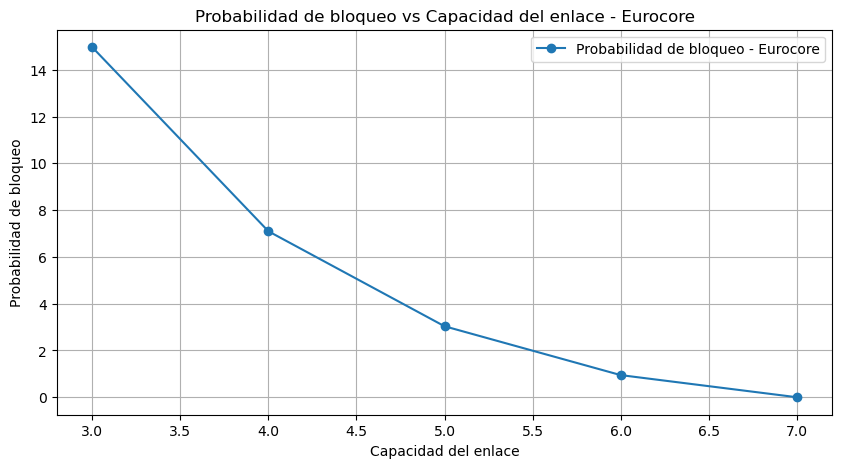

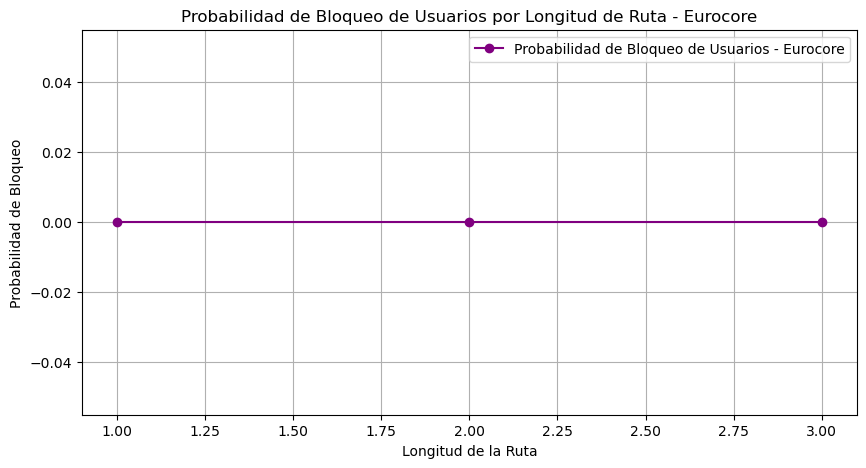

Métricas finales para Eurocore:
Probabilidad de bloqueo total: 0.000000
Probabilidades de bloqueo por usuario:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]







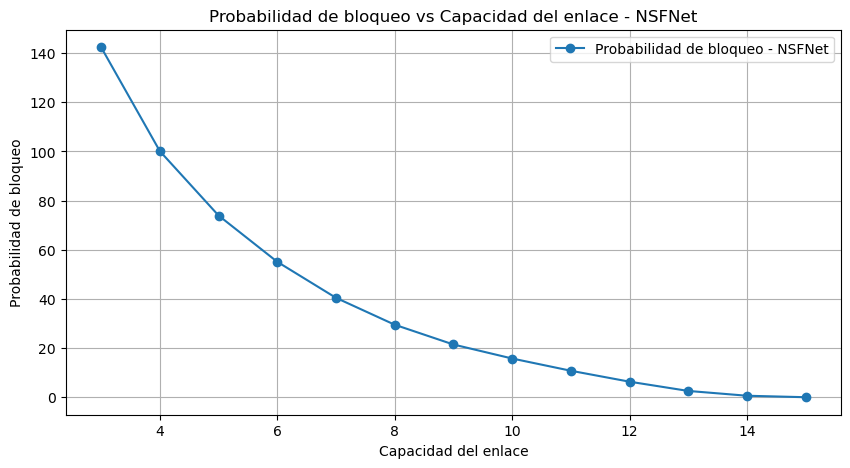

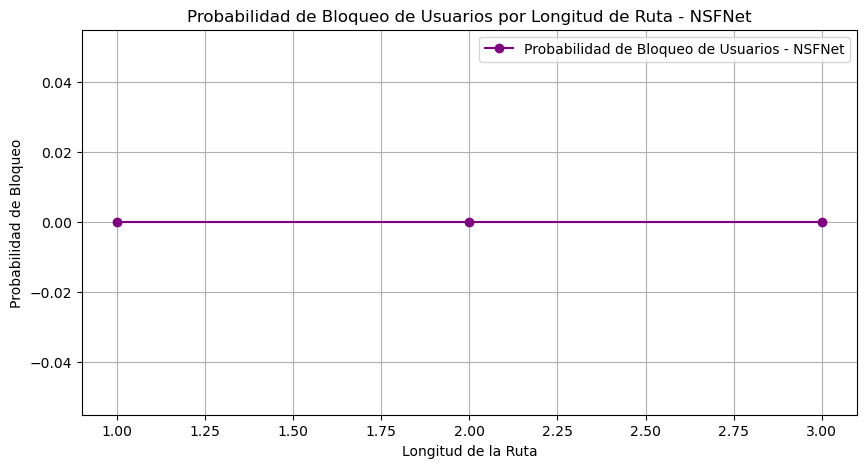

Métricas finales para NSFNet:
Probabilidad de bloqueo total: 0.000000
Probabilidades de bloqueo por usuario:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]







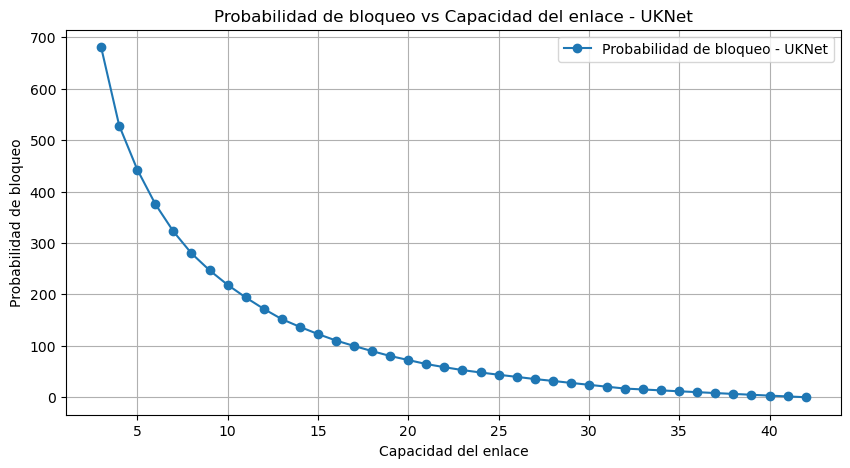

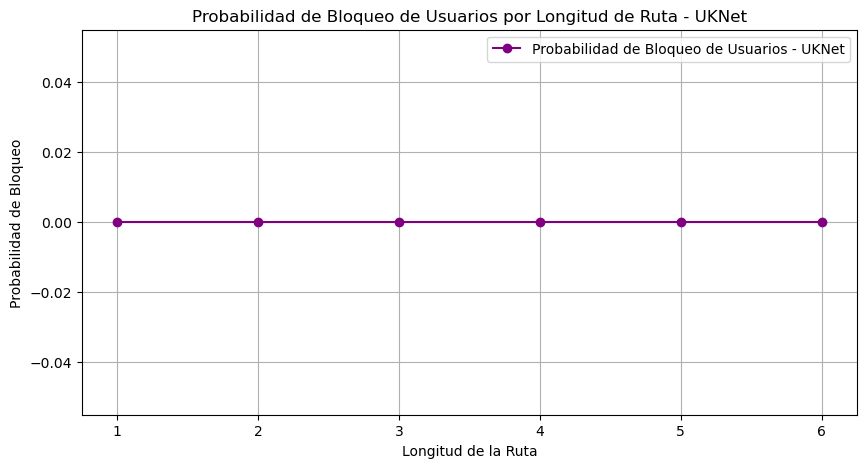

Métricas finales para UKNet:
Probabilidad de bloqueo total: 0.000000
Probabilidades de bloqueo por usuario:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

In [ ]:
###Ejecutar la simulación y generar gráficos para todas las topologías

#crear y ejecutar la simulación para cada topología
for nombre, (dfRuta, connection_counts_sorted, N, M, tasa_llegada) in topologias.items():
    #tiempo_ini = time.time()
    
    capacidades = []
    probabilidades_bloqueo = []
    C = C_inicial
    prob_bloqueo = 1

    while prob_bloqueo > 10**-3:
        simulacion = RedSimulacion(dfRuta, connection_counts_sorted, M, C, tasa_llegada, u)
        simulacion.simular()
        
        prob_bloqueo, _ = simulacion.resultados()
        
        capacidades.append(C)
        probabilidades_bloqueo.append(prob_bloqueo)
        
        C += 1

    plt.figure(figsize=(10, 5))
    plt.plot(capacidades, probabilidades_bloqueo, marker='o', label=f'Probabilidad de bloqueo - {nombre}')
    plt.xlabel('Capacidad del enlace')
    plt.ylabel('Probabilidad de bloqueo')
    plt.title(f'Probabilidad de bloqueo vs Capacidad del enlace - {nombre}')
    plt.legend()
    plt.grid(True)
    plt.show()

    C_optimo = capacidades[-1]

    simulacion = RedSimulacion(dfRuta, connection_counts_sorted, M, C_optimo, tasa_llegada, u)
    simulacion.simular()
    
    prob_bloqueo, probs_usuarios = simulacion.resultados()
    
    dfRuta["Prob Bloqueo"] = probs_usuarios
    
    df_grouped = dfRuta.groupby('LEN')['Prob Bloqueo'].mean()
    plt.figure(figsize=(10, 5))
    df_grouped.plot(kind="line", marker='o', color='purple', legend=True, label=f'Probabilidad de Bloqueo de Usuarios - {nombre}')
    plt.xlabel('Longitud de la Ruta')
    plt.ylabel('Probabilidad de Bloqueo')
    plt.title(f'Probabilidad de Bloqueo de Usuarios por Longitud de Ruta - {nombre}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Métricas finales para {nombre}:")
    print(f"Probabilidad de bloqueo total: {prob_bloqueo:.6f}")
    print(f"Probabilidades de bloqueo por usuario:")
    print(probs_usuarios)
    print("\n\n\n\n")
    
    #tiempo_final = time.time()
    #tiempo = tiempo_final - tiempo_ini
    #print(f"(Tiempo real necesario: {tiempo/60:.6f} mins.)\n\n\n\n") #medición de tiempo real que demora la simulación

## Conclusión

En esta simulación, hemos evaluado la probabilidad de bloqueo en diversas topologías de redes de transporte de internet de fibra óptica: Eurocore, NSFNet, UKNet y USNet. A continuación, se presentan las conclusiones basadas en los resultados obtenidos:

1. Topología Eurocore: 

La probabilidad de bloqueo disminuye significativamente al aumentar la capacidad de los enlaces, mostrando una tendencia esperada en una red bien dimensionada.

A pesar del aumento de la capacidad, la probabilidad de bloqueo por longitud de ruta se mantuvo en cero, indicando que la capacidad mínima de los enlaces fue suficiente para evitar bloqueos en la mayoría de las rutas.

2. Topología NSFNet:

La probabilidad de bloqueo muestra una disminución constante con el aumento de la capacidad de los enlaces, reflejando una mejora en la eficiencia de la red.

Al igual que en Eurocore, la probabilidad de bloqueo por longitud de ruta se mantuvo en cero, lo que sugiere una configuración de red adecuada para la demanda de tráfico simulada.

3. Topología UKNet:

La probabilidad de bloqueo presenta una curva decreciente con el aumento de la capacidad de los enlaces, similar a las otras topologías.

La probabilidad de bloqueo por longitud de ruta también se mantuvo en cero, indicando que la capacidad mínima de los enlaces fue suficiente para evitar bloqueos en las rutas simuladas.

4. Topología USNet:

La simulación para la topología USNet no pudo completarse debido a problemas de optimización de código y/o errores no corregidos, resultando en una ejecución extremadamente larga (muchas horas sin finalizar la ejecución final del código).

Este problema sugiere la necesidad de revisar y optimizar el código para manejar adecuadamente redes más grandes o con configuraciones más complejas.

## Conclusión Final

La simulación ha demostrado que incrementar la capacidad de los enlaces reduce la probabilidad de bloqueo en redes de transporte de internet de fibra óptica. No obstante, es crucial mejorar la optimización del código para manejar topologías de mayor escala, como USNet, para garantizar resultados precisos y eficientes en futuros estudios.